In [1]:
#@title
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

##<font color='navy' face='arial' size=12pt>More Applications with NLP</font>

## Application to wine ratings based on customer reviews

In [4]:
import re
import pandas as pd
import numpy as np
#!pip install nltk
from nltk import download
download('stopwords')
from nltk.corpus import stopwords

# For stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

#import CountVectorizer if we just want a Bag of Words Model
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures


from sklearn.metrics import accuracy_score as AC, confusion_matrix as CM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnelk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
wine_data = pd.read_csv('Data/winemagdata130kv2.csv',quoting=2)

In [8]:
display(wine_data.head(2))
display(wine_data.description)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0.0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87.0,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1.0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87.0,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 129971, dtype: object

In [11]:
ratings = wine_data.points.astype('int32').values 
np.unique(ratings) #we can see this as an NLP classification problem with 21 classes

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100])

In [23]:
# here we do our text pre-processing
documents = []

for i in range(0,len(wine_data)):
    #here we discard the punctuation and the special characters
    wine_descriptions = re.sub('[^a-zA-Z0-9 ]','',wine_data["description"][i])
    # here we change all letter to lower case
    wine_descriptions = wine_descriptions.lower()
    # here we tokenize the sentences - each sentence is then an array (list) of words
    wine_descriptions = wine_descriptions.split()
    # here we loop through the different words from the sentences and throw away the "stopwords"
    wine_descriptions = [word for word in wine_descriptions if not word in set(stopwords.words('english'))]
    # here we loop through the different words and we stem them
    stemmer = PorterStemmer()
    wine_descriptions = [stemmer.stem(word) for word in wine_descriptions]
    wine_descriptions = " ".join(wine_descriptions)
    documents.append(wine_descriptions)

In [ ]:
documents[0]

'onequart wine ferment neutral oak rest stainless steel 125 alcohol light almost airi wine bring immacul fruit flavor appl pear pleas miner mouthfeel offer faintest suggest caramel wind'

In [ ]:
# in the variable documents we should have ALL the different reviews
len(set(documents[0].split(' ')).union(set(documents[1].split(' '))))

50

In [ ]:
# Here we make a Bag of Words model so we need the CountVectorizer
countVec = CountVectorizer()
X = countVec.fit_transform(documents)

In [ ]:
X

<40000x20632 sparse matrix of type '<class 'numpy.int64'>'
	with 969159 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape
# X so X can be taken as the input features for a machine learning classifier

(40000, 20632)

In [ ]:
# here we designate the output variable and check if we have a class imbalance
y = wines_subset["points"]
y = y.where(y>=90,other=0).where(y<90,other=1).values

In [ ]:
# we chose a classfier and we applied it on the whole data (for testing purpuses)
model = LogisticRegression(solver='lbfgs', max_iter=10000)
#model.fit(X,y)

In [ ]:
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred = model.predict(X)
AC(y,pred)

0.9092

In [ ]:
pd.DataFrame(data=CM(y,pred),columns=['Below 90 points','At least 90 points'],index=['Below 90 points','At least 90 points'])

,Below 90 points,At least 90 points
Below 90 points,23501,1447
At least 90 points,2185,12867


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=310)

In [ ]:
# the loop for cross-validations
accuracies = []
i = 0
for train,test in skf.split(X,y):
  Xtrain = X[train,:]
  ytrain = y[train]
  Xtest  = X[test,:]
  ytest  = y[test]
  model.fit(Xtrain,ytrain)
  accuracies.append(AC(ytest,model.predict(Xtest)))
  print(accuracies[i])
  i=i+1

0.83025
0.837375
0.834875
0.841375
0.838625


In [ ]:
# here the estimation for accuracy is 
np.mean(accuracies)

0.8365000000000002

In [ ]:
sum(y)/len(y)

0.3763

In [ ]:
# here we can make a TF-IDF approach
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tf_idf = vectorizer.fit_transform(documents)

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=20,min_samples_leaf=400)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000,max_depth=1000,min_samples_leaf=100,random_state=310)

In [ ]:
model.fit(X_tf_idf,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=310,
                       verbose=0, warm_start=False)

In [ ]:
AC(y,model.predict(X_tf_idf))

NotFittedError: ignored

In [ ]:
from sklearn.svm import SVC
modelsvc = SVC(kernel='poly',degree=3,,C=2.0)

In [ ]:
modelsvc.fit(X_tf_idf,y)

SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
AC(y,modelsvc.predict(X_tf_idf))

0.99795

In [ ]:
# here we compute the KFold accuracies
accuracies = []
i = 0
for train,test in skf.split(X_tf_idf,y):
  Xtrain = X_tf_idf[train,:]
  ytrain = y[train]
  Xtest  = X_tf_idf[test,:]
  ytest  = y[test]
  modelsvc.fit(Xtrain,ytrain)
  accuracies.append(AC(ytest,modelsvc.predict(Xtest)))
  print(accuracies[i])
  i=i+1

0.837
0.842
0.839625
0.84675
0.839625


In [ ]:
np.mean(accuracies)

0.841

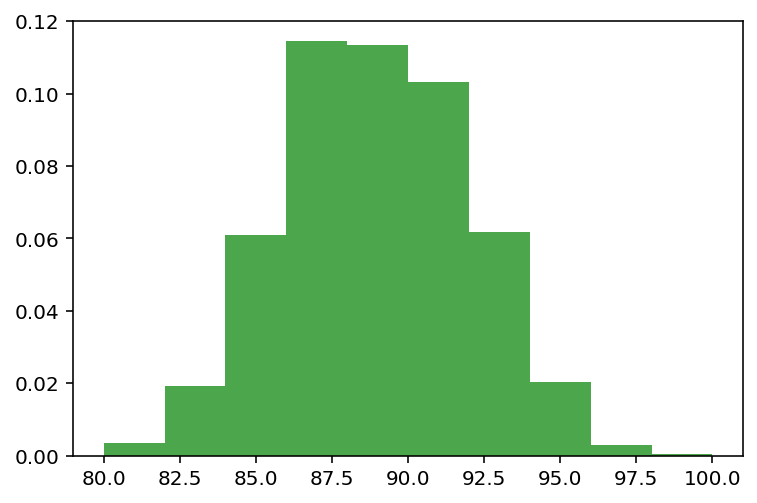

In [ ]:
#### Visualize the distribution of the wine ratings (points)
n, bins, patches = plt.hist(wines_subset["points"].values,10,density=1,facecolor='green',alpha=0.7)

In [ ]:
y = wines_subset["points"]
y = y.where(y>90,other=0).where(y<=90,other=1).values

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X,y,test_size=0.25,random_state=1693)
#scale_X = StandardScaler()
#X_train = scale_X.fit_transform(X_train)
#X_test = scale_X.transform(X_test)
classifier = LogisticRegression(random_state=1693,solver='lbfgs')
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)

In [ ]:
spc = ['Bad','Good']
cm = confusion_matrix(Y_test,Y_pred)
pd.DataFrame(cm, columns=spc, index=spc)

###<font color='blue'> Probabilistic Language Modeling 

**Goal:** Assign the probability that a sequence of words such as $(w_1,w_2,w_3,...w_n)$ occurs:

$$\mathcal{P}(\text{Sentence})=\mathcal{P}(w_1,w_2,w_3,...w_n)=\mathcal{P}(w_1)*\mathcal{P}(w_2,w_3,w_4...w_n|w_1)=$$

Smartphones use this information to predict what the next word you will type will be, for example:

$$\mathcal{P}(w_1,w_2,w_3,w_4)=\mathcal{P}(w_1)*\mathcal{P}(w_4,w_3,w_2|w_1)=\mathcal{P}(w_1)*\mathcal{P}(w_2|w_1)*\mathcal{P}(w_4,w_3|w_2,w_1)=\mathcal{P}(w_1)*\mathcal{P}(w_2|w_1)*\mathcal{P}(w_3|w_1,w_2)*\mathcal{P}(w_4|w_1,w_2,w_3)$$ 

which mean the probability of word $w_4$ provided the words $w_1, w_2$ and $w_3$ occurred.

IMPORTANT: we get a chained application of the Conditional Probability Rule.

<font face='Calibri' color='blue' size=4pt>Critical thinking:</span> How do we compute these probability values?</font>

<span style="font-family:Calibri; color:red; font-size:14pt;">Reasoning:</span> We compute the frequency of occurrence for different sequences of words.


<span style="font-family:Calibri; color:darkgreen; font-size:12pt;"> P(today | It, is, sunny) = 50%
The model you use to predict is called the “language model” </span>


<span style="font-family:Calibri; color:purple; font-size:14pt;"> Important Concept:</span> The Conditional Probability Rule states that probabilities of an events in the future are defined by the multiplication of all (conditional) probabilities leading to that given event.

P(Today, it, was, sunny) = P(Today) * P(it | Today) * P(was | Today, it) * P(sunny | Today, it, was)

P(Today, is, the, fiftennth) = P(Today) * P(is | Today) * P(the | Today, is) * P(fifteenth | Today, is, the)

1. Unigram Models:
        a. P(rainy | Today, it, was) ~ P(Today) * P(it) * P(was)
2. Bigram Models:
        a. P(rainy| Today, it, was) ~ P(rainy | was)
3. N-gram models:
        a. Same as the above, but for arbitrary distances.
        b. For example a tri-gram: P(rainy | Today, it, was)
            
Often used in nested ways (i.e., a 3-gram model + unigram).


### Evaluating NLP

• The goal of any NLP activity is important in deciding how to evaluate it.

• In a Bag of Words model, evaluation can come from classification accuracy (i.e., you have a training and test dataset).

• But what if you’re writing an algorithm that predicts the next word for a texting app?

### Perplexity an evaluative measure for NLP

One might expect a model to be good at predicting cold in this sentence:

“It is cold.”

And not as good at predicting:

“It is very cool outside when the winter is cold”

For a variety of reasons; the biggest is the complexity/length of the sentence.

• Perplexity is a measurement of how well a probability model predicts a test data. In the context of Natural Language Processing, perplexity is one way to evaluate language models.

• Perplexity is an exponentiation of the entropy.

• Low perplexity is good and high perplexity is bad since the perplexity is the exponentiation of an *entropy*.

• The goal is to minimize Perplexity(W).

Calculation of perplexity for a full a sequence of words: 

$$\sqrt{\prod_{i=1}^{n}\frac{1}{P(w_i|w_{1}w_{2}...w_{i-1})}}$$

Important applciations for Natural Language Processing:
	
    • Sentiment Analysis
	
    • Speech Recognition
	
    • Information Retrieval

    • Question Answering

<span style="font-family:Calibri; color:blue; font-size:14pt;">Big Idea:</span> Represent words as vectors: GloVe, Word2Vec algorithms (both are based on neural networks). 

## Text Pre-Processing
<figure>
<center>
<img src='https://drive.google.com/uc?id=18NPGiY9qskAusVD-hzQQ0Lz2uZ8nRyiX' width='500px' />

<figcaption>Image Caption</figcaption></center>
</figure>

## CBOW (continuous Bag of Words)

**CBOW** predicts words from the surrounding context words; it treats one context as one independent observation.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1L7Ol7refO3mMo92dTytS4CShUfPnsmCB' width='250px' />



The CBOW model architecture (Source: https://arxiv.org/pdf/1301.3781.pdf Mikolov el al.)

## Global Vectors for Word Representations (GloVe)

Example for using the vector words:  <font color='red'>monarch - man = queen.</font>

The main idea is that we can do more than just counting occurences but rather represent the words from the vocabulary of a language as vectors whose entries are real numbers. As such, the GloVe algorithm is analysing word *co-occurrencies* within a text corpus; the steps are as follows:

1.   A *co-occurence* matrix $X$ is created where its entries $X_{ij}$ represent how often word $i$ is present in the context of the word $j$. Thus there is a parsing of the corpus for building the matrix $X$ and then the model is constructed based on this matrix.
2.   For the words $i$ and $j$ we create vectors $\vec{w}_i$ and $\vec{w}_j$ such that $$\vec{w}_i^T\cdot\vec{w}_j+b_i+b_j=\log (X_{ij})$$ where $b_i$ and $b_j$ are scalar *bias* terms (such as the *y-intercepts* for a linear regression model). We want to build word vectors that retain useful information of how words $i$ and $j$ co-occur.
3.   In order to determine the entries for the *word vectors* $\vec{w}_i$, we minimize the following objective function $$J:=\sum_{i=1}^{V}\sum_{j=1}^{V}f(X_{ij}) \left(\vec{w}_i^T\cdot\vec{w}_j+b_i+b_j-\log (X_{ij})\right)^2$$
4.   The function $f$ is chosen in order to prevent the skewing of the objective function by the words that co-occur too often. In this sense a choice for the function $f$ could be $$f(X_{ij}):=\begin{cases}
\left(\frac{X_{ij}}{x_{max}}\right)^{\alpha} \text{if} \;\; X_{ij}<x_{max} \\
1 \;\;\; \text{otherwise}
\end{cases}
$$ where $\alpha$ and $x_{max}$ can be adjusted by the user. 

In [ ]:
!pip install glove-python-binary

     |████████████████████████████████| 948 kB 33.2 MB/s 


In [ ]:
from glove import Corpus, Glove

In [ ]:
text = [['Hello', 'this','presentation', 'on', 'how','convert' ,'word','number','format'],
        ['this' ,'beautiful', 'day'],['Daniel','will','going' , 'office','today'],
        ['Want', 'also','introduce','Colab','good','tool','convert','word','number']]
# text = "The chocolate is delicious but it may not be always good for you. Homemade chocolate is fun to make. There are many recipes online."
# creating a corpus object
corpus = Corpus() 
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(text, window=10)
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=5, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [ ]:
glove.most_similar('Hello')

[('format', 0.9377103562998411),
 ('number', 0.794133910513137),
 ('Daniel', 0.6019566689918101),
 ('convert', 0.4698554931090687)]

In [ ]:
print(corpus.matrix)

## GloVe Application

In [ ]:
import re
import nltk
import pprint
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
text = open("drive/My Drive/Colab Notebooks/Christmas_Carol.txt").read()

In [ ]:
dataset = nltk.sent_tokenize(text) 
for i in range(len(dataset)): 
    dataset[i] = dataset[i].lower() 
    dataset[i] = re.sub(r'\W', ' ', dataset[i]) 
    dataset[i] = re.sub(r'\s+', ' ', dataset[i]) 

In [ ]:
dataset[200]

' you ll want all day to morrow i suppose '

In [ ]:
def InfoExtract(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]

In [ ]:
InfoExtract(text)

In [ ]:
sentences = [nltk.word_tokenize(sent) for sent in dataset]

In [ ]:
sentences[327]

['scrooge',
 'fell',
 'upon',
 'his',
 'knees',
 'and',
 'clasped',
 'his',
 'hands',
 'before',
 'his',
 'face']

### Here we apply the GloVe algorithm to create word vectors:

In [ ]:
corpus = Corpus() 
corpus.fit(sentences, window=12)
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=10, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=1000, no_threads=20, verbose=False)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [ ]:
corpus.matrix

<4262x4262 sparse matrix of type '<class 'numpy.float64'>'
	with 122623 stored elements in COOrdinate format>

In [ ]:
glove.most_similar('christmas')

[('day', 0.9185604412013397),
 ('merry', 0.9156450891535083),
 ('business', 0.90382657617194),
 ('sends', 0.861967957395055)]

## Word2Vec

It is a combination of models for representing the contextual distribution of words in a corpus.

Playground: http://projector.tensorflow.org/

There are two main algorithms: **CBOW** (Continuous Bag of Words) and **Skip-Gram**.

**CBOW** predicts words from the surrounding context words; it treats one context as one independent observation.

**Skip-Gram** predicts the surrounding context words from the target words (in a sense it is the "inverse" of CBOW)

In [ ]:
# importing all necessary modules 
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Test Pre-processing

In [ ]:
#  Reads text file 
sample = text
  
# Replaces escape character with space 
#f = s.replace("\n", " ") 

f = text
  
data = [] 
  
# iterate through each sentence in the file 
for i in sent_tokenize(f): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        temp.append(j.lower()) 
  
    data.append(temp)

In [ ]:
data[234]

['and', 'closed', 'it', 'with', 'a', 'bang', '.']

### CBOW Model

In [ ]:
# Create CBOW model 
model1 = gensim.models.Word2Vec(data, min_count = 1,  
                              size = 50, window = 9,sg=0) 
# Print results 
print("Cosine similarity between 'candle' " + 
               "and 'christmas' - CBOW : ", 
    model1.similarity('candle', 'christmas')) 
      
print("Cosine similarity between 'scrooge' " +
                 "and 'christmas' - CBOW : ", 
      model1.similarity('scrooge', 'christmas')) 

Cosine similarity between 'candle' and 'christmas' - CBOW :  0.98483485
Cosine similarity between 'scrooge' and 'christmas' - CBOW :  0.99985504


### Skip-Gram Model

In [ ]:
# Create Skip Gram model 
model2 = gensim.models.Word2Vec(data, min_count = 1, size = 50, 
                                             window = 9, sg = 1) 
  
# Print results 
print("Cosine similarity between 'ghost' " + 
               "and 'christmas' - Skip-Gram : ", 
    model2.similarity('ghost', 'christmas')) 
      
print("Cosine similarity between 'scrooge' " +
                 "and 'christmas' - Skip-Gram : ", 
      model2.similarity('scrooge', 'christmas')) 

Cosine similarity between 'ghost' and 'christmas' - Skip-Gram :  0.99325514
Cosine similarity between 'scrooge' and 'christmas' - Skip-Gram :  0.9892585


In [ ]:
model1.wv.most_similar(positive='ghost')

[('with', 0.9999064803123474),
 ('on', 0.9999052286148071),
 ('an', 0.9999028444290161),
 ('in', 0.9999011158943176),
 ('there', 0.9998980760574341),
 (',', 0.9998955726623535),
 ("'s", 0.9998926520347595),
 ('we', 0.9998918771743774),
 ('and', 0.9998918771743774),
 ('by', 0.9998900890350342)]